In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
class LogisticsRegression(nn.Module):
    def __init__(self, in_dim):
        """
        *********请在此处输入你的代码*********
        定义模型参数w，以及非线性sigmoid函数
        """
        super().__init__()  # 等价于nn.Module.__init__()
        self.w = nn.Parameter(torch.randn(in_dim+1, 1)*0.01)

    def forward(self, x):
        """
        *********请在此处输入你的代码*********
        定义模型函数：f = sigmoid(<w, x>)
        输入：x矩阵，每一行对应一个数据样本
        输出（返回值）：每一个数据样本的输出（预测）
        """
        # x是size*dim的矩阵，将x变为size*(dim+1)的矩阵
        x = torch.cat([x, torch.ones(x.shape[0], 1)], dim=1)
        # 求出概率f，其中w*x得到了1*size的矩阵
        f = torch.sigmoid(torch.matmul(x, self.w))
        return f

In [3]:
class Logistics_Model:
    """
    模型训练与测试类
    """

    def __init__(self, in_dim):
        """
        *********请在此处输入你的代码*********
        输入：输入数据的维度 in_dim
        定义类的属性：包括训练步长、轮数、逻辑斯蒂回归模型、优化器、损失函数
        输出：无返回变量
        """
        self.learning_rate = 0.01
        self.epoches = 1000
        self.model = LogisticsRegression(in_dim)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
        self.loss_function = nn.BCELoss()

    def train(self, x, y):
        """
        训练模型
        输入:
            x: 训练数据矩阵
            y: +1/-1列表，分类标签

        定义迭代优化过程：一共优化指定的轮数

        返回:
            losses: 训练中每一轮的损失值（画图用）
        """
        losses = []
        
        for epoche in range(self.epoches):
            prediction = self.model(x)

            Loss = self.loss_function(prediction, y)
            self.optimizer.zero_grad()
            Loss.backward()
            self.optimizer.step()
            losses.append(Loss.item())

        return losses

    def test(self, x, y):
        """
        用训练好的模型做测试
        输入:
            x: 测试数据
            y: 测试数据的真实标签
        过程：使用训练好的模型，预测x的标签，并且与y进行对比，计算预测精度
        返回:
            prediction: 每一个测试数据的预测值
            accuracy: 数值，模型的精度
        """
        #print(y[:10])
        prediction = self.model(x)
        pre_label = (prediction >= 0.5).to(torch.int)
        true = (pre_label -y<1e-8).sum().item()
        acc = true / x.shape[0]
        #print(prediction[:10])
        return prediction, acc

In [4]:
def create_linear_data(data_size, in_dim):
    """
    为线性模型生成数据
    输入:
        data_size: 样本数量
    返回:
        x_train: 训练数据
        y_train: 训练数据回归真值
        x_test: 测试数据
        y_test: 测试数据回归真值
    """
    np.random.seed(426)
    torch.manual_seed(426)
    torch.cuda.manual_seed(426)
    # *********修改的代码：数据生成，跟之前的那次代码一样，复制修改来的*********
    # 正负样本个数
    m_pos = data_size // 2
    m_neg = data_size - m_pos
    X = np.zeros((in_dim, data_size))
    Y = np.zeros((1, data_size))

    x1 = np.random.normal(loc=-1, scale=3, size=(1, m_pos))
    X[0:1, 0:m_pos] = x1
    # 整体线性分布
    X[1:2, 0:m_pos] = 2 * x1 + 10 + 0.1 * x1**2
    # 加噪声
    X[1:2, 0:m_pos] += np.random.normal(loc=0, scale=5, size=(1, m_pos))
    Y[0, 0:m_pos] = 1

    x1 = np.random.normal(loc=1, scale=3, size=(1, m_neg))
    X[0:1, -m_neg:] = x1
    X[1:2, -m_neg:] = 2 * x1 - 5 - 0.1 * x1**2
    X[1:2, -m_neg:] += np.random.normal(loc=0, scale=5, size=(1, m_neg))

    X = torch.Tensor(X.T)
    Y = torch.Tensor(Y.T)
    # X = torch.Tensor(data_size, in_dim).uniform_(1, 10)
    # map_true = torch.Tensor(in_dim, 1).uniform_(-5, 5)
    # #map_true = torch.tensor([[1.5],[-5.],[3.]], dtype=torch.float32)
    # print('w真值:{}'.format(map_true))

    # Y = X.mm(map_true) + 10. + torch.FloatTensor(data_size,
    #                                              1).normal_(0, 10)  # torch.randn(x.size())

    shuffled_index = np.random.permutation(data_size)
    shuffled_index = torch.from_numpy(shuffled_index).long()
    X = X[shuffled_index]
    Y = Y[shuffled_index]
    split_index = int(data_size * 0.7)
    x_train = X[:split_index]
    y_train = Y[:split_index]
    x_test = X[split_index:]
    y_test = Y[split_index:]

    return x_train, y_train, x_test, y_test

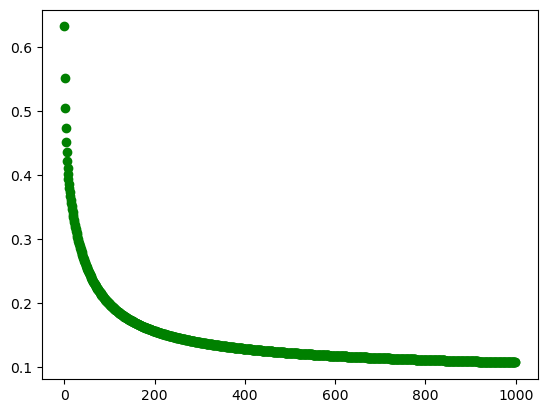

测试集上accuracy:0.95
w Parameter containing:
tensor([[-1.1180],
        [ 0.4478],
        [-0.0019],
        [-0.4059]], requires_grad=True)


In [5]:
# 生成数据
data_size = 200
in_dim = 3
x_train, y_train, x_test, y_test = create_linear_data(data_size, in_dim)

# 线性回归模型实例化
logistics = Logistics_Model(in_dim)
# 模型训练
losses = logistics.train(x_train, y_train)
plt.figure()
plt.scatter(np.arange(len(losses)), losses, marker="o", c="green")
plt.show()
# 模型测试
prediction, accuracy = logistics.test(x_test, y_test)
print("测试集上accuracy:{}".format(accuracy))
# 打印参数
for name, parameter in logistics.model.named_parameters():
    print(name, parameter)